In [1]:
# Lectura de datos
# ------------------------------------------------------------------------------
import pickle

# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Barra de progreso de un proceso
# ------------------------------------------------------------------------------
from tqdm import tqdm

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [2]:
# Para ejecutar en google colab
#from google.colab import drive
#drive.mount('/content/drive/')

In [3]:
# Para conectar con Drive
#%cd /content/drive/My Drive/Colab Notebooks/

In [4]:
#import os

In [5]:
# Lectura del fichero
df = pd.read_pickle("datos/4.reg_encoding_oh_final.pkl")
#df = pd.read_csv("project-da-promo-C-module-3-team-5/datos/4.reg_encoding_oh_final.csv", index_col=0)
df.head()

,yr,mnth,dia_anual,holiday_num,weekday_num,workingday_num,weathersit,temp,atemp,hum,windspeed,registered,seasons_autumn,seasons_spring,seasons_summer,seasons_winter
0,0,1,1,1,0,0,2,14.110847,18.18125,80.5833,10.749882,654,0.0,0.0,0.0,1.0
1,0,1,2,0,1,1,2,14.902598,17.68695,69.6087,16.652113,670,0.0,0.0,0.0,1.0
2,0,1,3,0,2,1,1,8.050924,9.47025,43.7273,16.636703,1229,0.0,0.0,0.0,1.0
3,0,1,4,0,3,1,1,8.200000,10.60610,59.0435,10.739832,1454,0.0,0.0,0.0,1.0
4,0,1,5,0,4,1,1,9.305237,11.46350,43.6957,12.522300,1518,0.0,0.0,0.0,1.0


In [6]:
# RandomForest
# X = Variables Predictoras
# y = Variable Respuesta
X = df[['holiday_num', 'weekday_num', 'workingday_num', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'seasons_autumn', 'seasons_spring', 'seasons_summer', 'seasons_winter']]
y = df['registered']

In [7]:
# Generamos los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 43)

In [8]:
# Definimos un diccionario con los hiperparámetros que deberemos ocupar en el random forest
param = {"max_depth": [4,6,8],
        "max_features": [4,5,6,7],
        "min_samples_split": [5, 20, 75], 
        "min_samples_leaf": [5,20,75]} 

In [9]:
# Aplicamos el GridSearch con estimador de RandomForestRegressor
gs_rf = GridSearchCV(
            estimator=RandomForestRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True) # para que nos devuelva el valor de las métricas de set de datos de entrenamiento

In [10]:
# Entrenamos el modelo con .fit()
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 6, 8], 'max_features': [4, 5, 6, 7],
                         'min_samples_leaf': [5, 20, 75],
                         'min_samples_split': [5, 20, 75]},
             return_train_score=True, verbose=-1)

In [11]:
with open("datos/7.reg_encoding_oh_final_gs_rf.pkl", "wb") as f:
    pickle.dump(gs_rf, f)

In [12]:
# método para que elija el mejor estimador o combinación de valores
bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=6, max_features=7, min_samples_leaf=5,
                      min_samples_split=5)

In [13]:
# Aplicamos el método .predict() para calcular las métricas del mejor modelo.
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

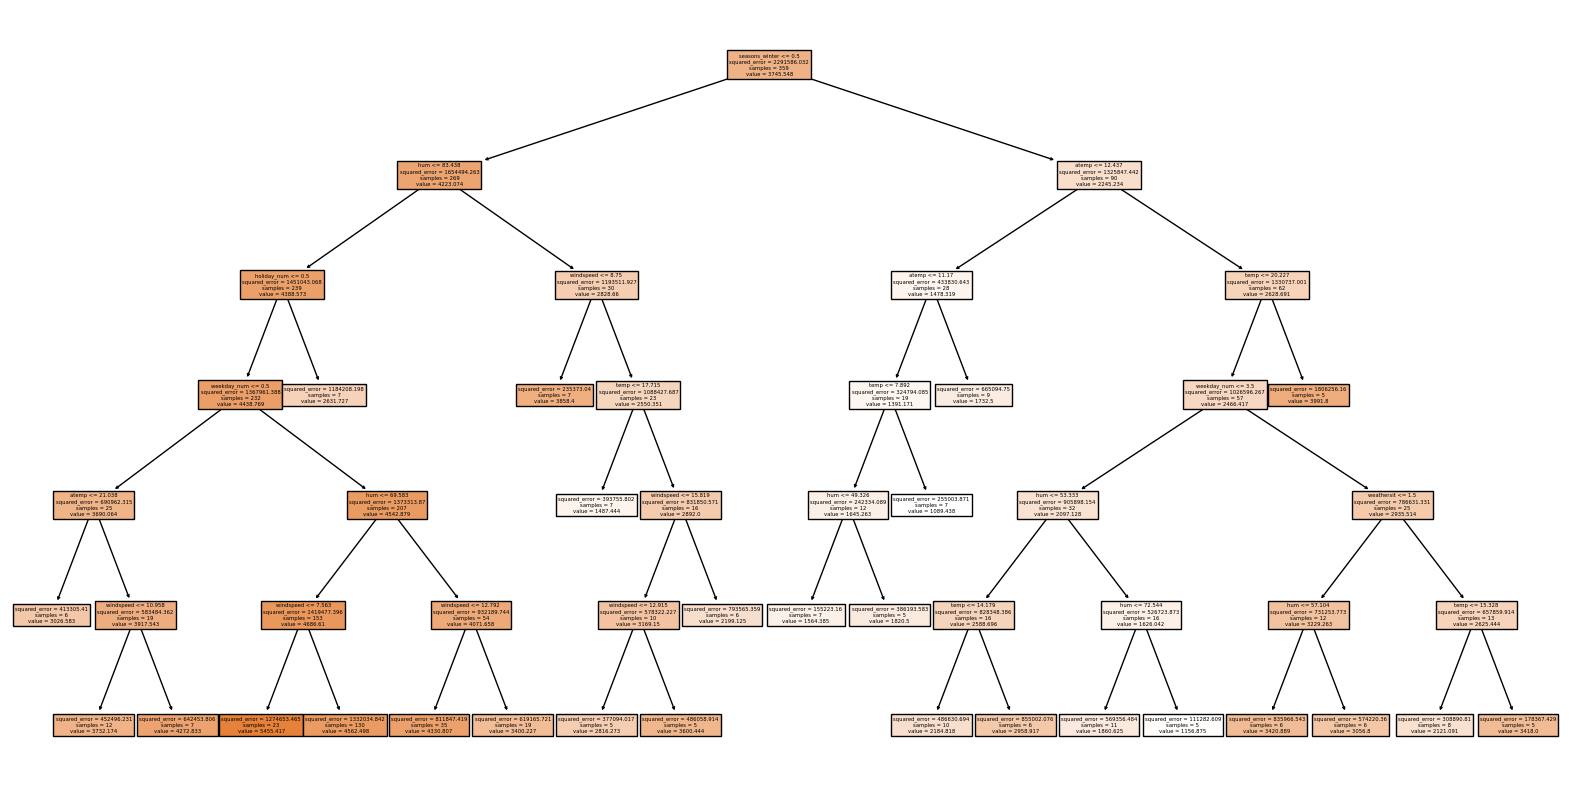

In [14]:
# Plotear un árbol del RandomForest
plt.figure(figsize=(20,10))
tree.plot_tree(bosque.estimators_[50],feature_names=x_train.columns,filled=True)
plt.show()

In [15]:
# Medimos las métricas del random forest
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [16]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados
rf_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Reg Cod Random Forest")
rf_results

,MAE,MSE,RMSE,R2,set,modelo
0,910.059669,1.175102e+06,1084.021138,0.471301,test,Reg Cod Random Forest
1,755.627702,7.847814e+05,885.878891,0.683687,train,Reg Cod Random Forest


In [17]:
# Cargamos el archivo con las mejores métricas del Decision Tree
df_DT_results = pd.read_csv("datos/6.reg_resultados_2_cod_est.csv", index_col = 0)
df_DT_results

,MAE,MSE,RMSE,R2,set,modelo
2,526.958790,486331.406888,697.374653,0.774698,test,Reg_est_Decision tree II Est-Cod
3,538.241508,508942.300858,713.401921,0.795858,train,Reg_est_Decision tree II Est-Cod
6,403.047749,264899.404086,514.683790,0.877280,test,Reg_Cod_Decision tree II
7,387.159792,244561.022740,494.531114,0.901904,train,Reg_Cod_Decision tree II


In [18]:
#Unimos los resultados del Random Forest y el Decision Tree:
df_RF_DT_results = pd.concat([df_DT_results, rf_results], axis=0)
df_RF_DT_results

,MAE,MSE,RMSE,R2,set,modelo
2,526.958790,4.863314e+05,697.374653,0.774698,test,Reg_est_Decision tree II Est-Cod
3,538.241508,5.089423e+05,713.401921,0.795858,train,Reg_est_Decision tree II Est-Cod
6,403.047749,2.648994e+05,514.683790,0.877280,test,Reg_Cod_Decision tree II
7,387.159792,2.445610e+05,494.531114,0.901904,train,Reg_Cod_Decision tree II
0,910.059669,1.175102e+06,1084.021138,0.471301,test,Reg Cod Random Forest
1,755.627702,7.847814e+05,885.878891,0.683687,train,Reg Cod Random Forest


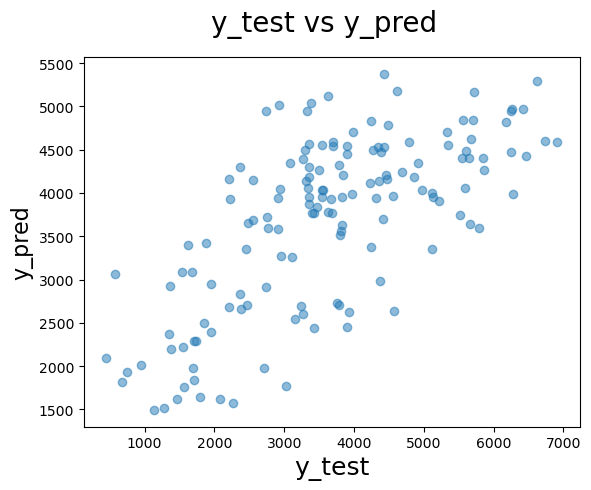

In [20]:
fig = plt.figure()
plt.scatter(y_test, y_pred_test_rf , alpha=.5)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)
plt.show()

<AxesSubplot:xlabel='registered', ylabel='Count'>

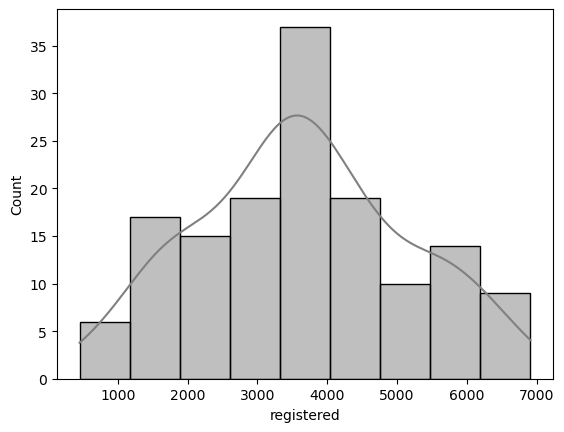

In [21]:
# ploteamos los residuos
sns.histplot(x= y_test,
             color ="grey",
             kde=True)

<AxesSubplot:ylabel='Count'>

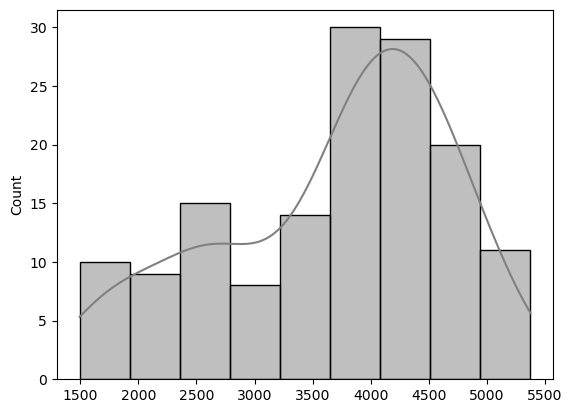

In [22]:
# ploteamos los residuos
sns.histplot(x= y_pred_test_rf,
             color ="grey",
             kde=True)

In [19]:
df_RF_DT_results.to_csv("datos/7.reg_resultados_cod_rf_mas_dt.csv")